<a href="https://colab.research.google.com/github/DragonVG/Twitter-Sentiment-Analysis/blob/main/Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
import emoji
import time
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
dataset = pd.read_excel('Train Data.xlsx',header=None)

In [ ]:
dataset.columns = ['Sentiment', 'ID', 'Date', 'Query', 'User_ID', 'Tweet']
dataset.head()

,Sentiment,ID,Date,Query,User_ID,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
print("Total tweets in the dataset: {} Million".format(dataset.shape[0]/1000000.0))

Total tweets in the dataset: 0.1 Million


In [ ]:
dataset.shape

(100000, 6)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentiment  100000 non-null  int64 
 1   ID         100000 non-null  int64 
 2   Date       100000 non-null  object
 3   Query      100000 non-null  object
 4   User_ID    100000 non-null  object
 5   Tweet      100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [ ]:
dataset.isnull().sum()

Sentiment    0
ID           0
Date         0
Query        0
User_ID      0
Tweet        0
dtype: int64

In [ ]:
dataset['Sentiment'] = dataset['Sentiment'].replace(4,1)

In [ ]:
average_characters = dataset['Tweet'].apply(len).mean()

In [ ]:
average_characters

73.9606

In [ ]:
# Calculate the number of characters in each tweet
dataset['num_characters'] = dataset['Tweet'].apply(len)

# Calculate the number of words in each tweet
dataset['num_words'] = dataset['Tweet'].apply(lambda x: len(x.split()))

# Calculate the number of unique words in each tweet
dataset['num_unique_words'] = dataset['Tweet'].apply(lambda x: len(set(x.split())))

# Calculate the 99th quantile for number of characters
quantile_99_characters = dataset['num_characters'].quantile(0.99)

# Calculate the average number of words
average_words = dataset['num_words'].mean()

# Calculate the number of words in the longest tweet
max_words_longest_tweet = dataset.loc[dataset['num_words'].idxmax()]['num_words']

# Calculate the number of words in the shortest tweet
min_words_shortest_tweet = dataset.loc[dataset['num_words'].idxmin()]['num_words']

# Calculate the 99th quantile for number of words
quantile_99_words = dataset['num_words'].quantile(0.99)

# Print the results
print(f"Average number of characters: {dataset['num_characters'].mean():.2f}")
print(f"Longest tweet characters: {dataset['num_characters'].max()}")
print(f"Shortest tweet characters: {dataset['num_characters'].min()}")
print(f"Number of characters of quantile 0.99: {quantile_99_characters:.2f}")

print(f"Average number of words: {average_words:.2f}")
print(f"Number of words in the longest tweet: {max_words_longest_tweet}")
print(f"Number of words in the shortest tweet: {min_words_shortest_tweet}")
print(f"Number of words of quantile 0.99: {quantile_99_words:.2f}")

print(f"Number of unique words: {dataset['num_unique_words'].sum()}")

Average number of characters: 73.96
Longest tweet characters: 186
Shortest tweet characters: 6
Number of characters of quantile 0.99: 141.00
Average number of words: 13.18
Number of words in the longest tweet: 41
Number of words in the shortest tweet: 1
Number of words of quantile 0.99: 28.00
Number of unique words: 1260915


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

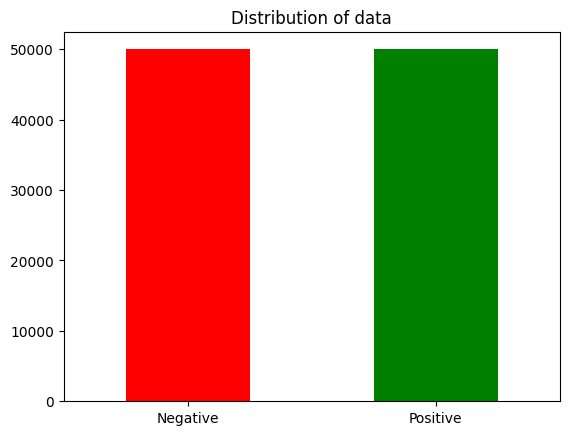

In [ ]:
ax = dataset['Sentiment'].value_counts().plot(kind='bar', title='Distribution of data',
                                               legend=False, color = ['r', 'g'])
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
print(dataset['Tweet'][0])
print(dataset['Tweet'][1])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [ ]:
pos_tweet = ''.join(dataset[dataset['Sentiment'] == 1]['Tweet'].str.lower())
neg_tweet = ''.join(dataset[dataset['Sentiment'] == 0]['Tweet'].str.lower())

In [ ]:
tweet_mask= np.array(Image.open('Twitter.jpeg'))

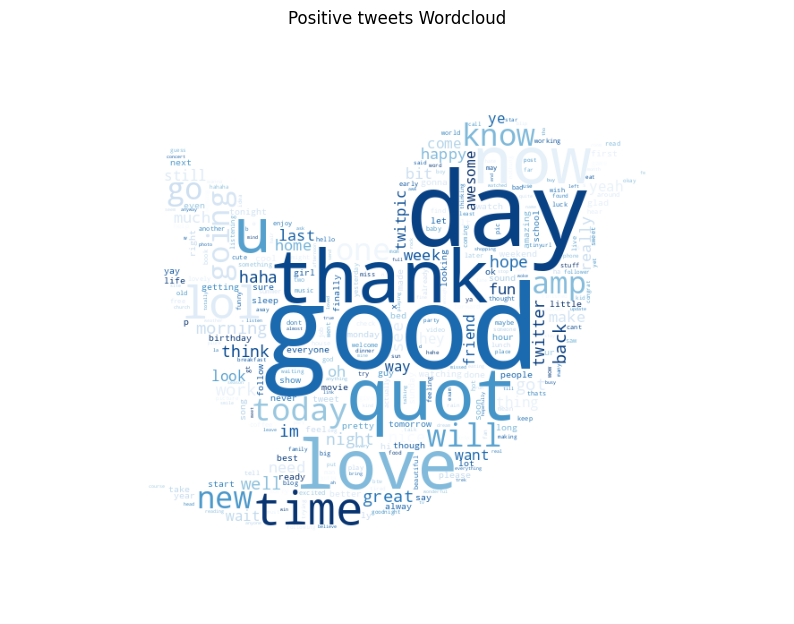

In [ ]:
from wordcloud import ImageColorGenerator

#Grab the mask colors
#Plot the wordcloud

wordcloud = WordCloud(mask=tweet_mask, colormap = 'Blues_r',stopwords = STOPWORDS, background_color = "white", max_words = 1000, width = 1600 , height = 800, collocations=False).generate(pos_tweet)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Positive tweets Wordcloud")
plt.show()

Text(0.5, 1.0, 'Negative tweets Wordcloud')

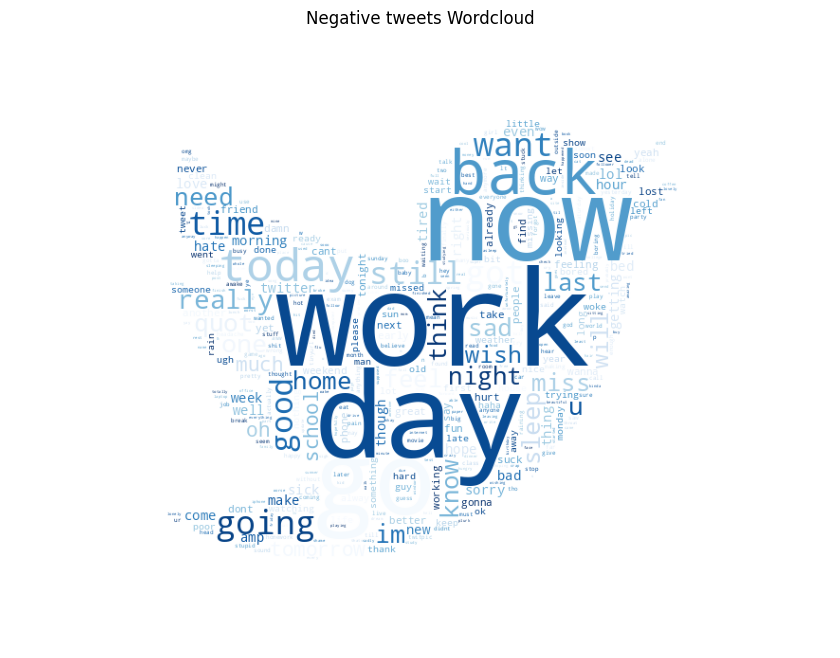

In [ ]:
wordcloud = WordCloud(mask = tweet_mask, colormap = 'Blues_r',stopwords = STOPWORDS, background_color = "white", max_words = 1000, width = 1600 , height = 800, collocations=False).generate(neg_tweet)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Negative tweets Wordcloud")

In [ ]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

In [ ]:
def clean_tweet(data, wordNetLemmatizer):
    data['Clean_tweet'] = data['Tweet']
    print("Removing user handles starting with @")
    data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
    print("Removing numbers and special characters")
    data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
    print("Removing urls")
    data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
    print("Removing single characters")
    data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
    print("Tokenizing tweets")
    data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: word_tokenize(tweet))
    print("Removing stopwords")
    data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
    print("Removing Emojis")
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [emoji_pattern.sub(r'', word) for word in tweet])
    print("Combining words back to tweets")
    data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
    return data

In [ ]:
def preprocess(text):
  text = text.lower()
  #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text) # remove URLs
  text = re.sub('<.*?>', '', text)   # remove HTML tags
  text = re.sub(r'[^\w\s]', '', text) # remove punc
  text = re.sub(r'\d+','',text)# remove numbers
  #text = re.sub(r"[.?!]", '', text)
  #text = re.sub('[0-9]+', '', text)
  text = re.sub('@(\w+)',"", text ) # remove usernames
  text = re.sub(r"[#|_]", '', text) # remove the # in #hashtag
  text = word_tokenize(text) # remove repeated characters (helloooooooo into hello)

  #removing stopwords and puncuations
  mystopword = set(nltk.corpus.stopwords.words('english') + ['URL'])
  text = [word for word in text if word not in mystopword]
  text = [word for word in text if word not in punctuation]

  # mystopwords = set(stopwords.words('english') + list(punctuation) + ['URL'])

  #apply lemmatizing
  wn = nltk.WordNetLemmatizer()
  text = [wn.lemmatize(word) for word in text]


  #apply stemming
  #ps = nltk.PorterStemmer()
  #text = [ps.stem(word) for word in text]

  return ' '.join(text)



In [ ]:
dataset['Clean_Tweet'] = dataset['Tweet'].apply(lambda x: preprocess(x))

In [ ]:
dataset.head()

,Sentiment,ID,Date,Query,User_ID,Tweet,Clean_Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccomyzl awww thats bummer...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many time ball managed save res...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see


In [ ]:
dataset = dataset.drop(['ID', 'Date', 'Query', 'User_ID', 'Tweet'], axis=1)
dataset.head()

,Sentiment,Clean_Tweet
0,0,switchfoot httptwitpiccomyzl awww thats bummer...
1,0,upset cant update facebook texting might cry r...
2,0,kenichan dived many time ball managed save res...
3,0,whole body feel itchy like fire
4,0,nationwideclass behaving im mad cant see


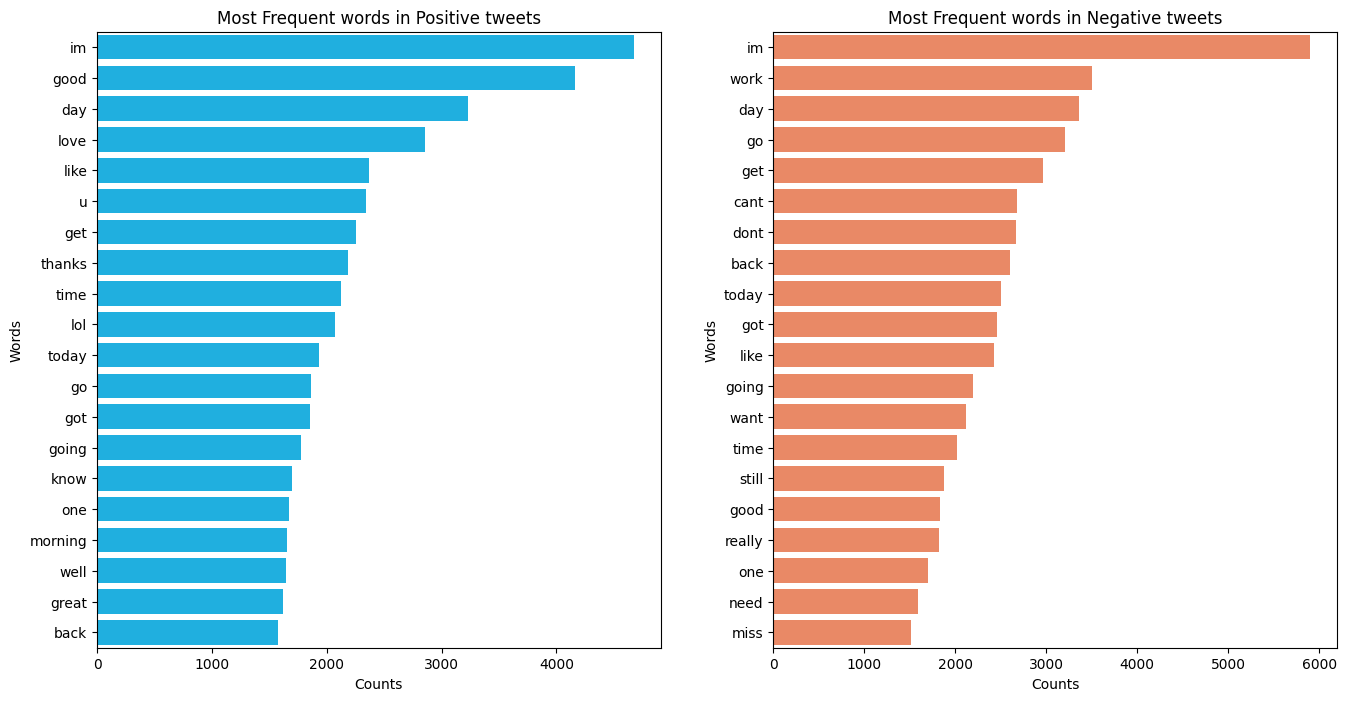

In [ ]:
negatives=dataset['Sentiment']==0
positives=dataset['Sentiment']==1

# Number of words for each tweet
dataset['No_of_Words']=[len(text.split()) for text in dataset['Clean_Tweet']]


dataset['Words'] = dataset['Clean_Tweet'].apply(lambda x:str(x).split())

top_pos = Counter([word for text in dataset[positives]['Words'] for word in text])
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter([word for text in dataset[negatives]['Words'] for word in text])
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,8))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
plt.show()

In [ ]:
# Define processing methods
wordNetLemmatizer = WordNetLemmatizer()

In [ ]:
#Pre-processing the tweets
new_dataset = clean_tweet(dataset, wordNetLemmatizer)

Removing user handles starting with @
Removing numbers and special characters


<ipython-input-17-bacf62af20c5>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
<ipython-input-17-bacf62af20c5>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")


Removing urls
Removing single characters
Tokenizing tweets
Removing stopwords
Removing Emojis
Combining words back to tweets


In [ ]:
new_dataset.head()

,Sentiment,ID,Date,Query,User_ID,Tweet,Clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",httptwitpiccomyzl Awww 's bummer You shoulda g...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset ca n't update Facebook texting might cry...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many times ball Managed save The rest go...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",'s not behaving 'm mad ca n't see


In [ ]:
new_dataset = new_dataset.drop(['ID', 'Date', 'Query', 'User_ID', 'Tweet'], axis=1)

In [ ]:
new_dataset.head()

,Sentiment,Clean_tweet
0,0,httptwitpiccomyzl Awww 's bummer You shoulda g...
1,0,upset ca n't update Facebook texting might cry...
2,0,dived many times ball Managed save The rest go...
3,0,whole body feels itchy like fire
4,0,'s not behaving 'm mad ca n't see


In [ ]:
# Calculate the number of characters in each tweet
new_dataset['num_characters'] = new_dataset['Clean_tweet'].apply(len)

# Calculate the number of words in each tweet
new_dataset['num_words'] = new_dataset['Clean_tweet'].apply(lambda x: len(x.split()))

# Calculate the number of unique words in each tweet
new_dataset['num_unique_words'] = new_dataset['Clean_tweet'].apply(lambda x: len(set(x.split())))

# Calculate the 99th quantile for number of characters
quantile_99_characters = new_dataset['num_characters'].quantile(0.99)

# Calculate the average number of words
average_words = new_dataset['num_words'].mean()

# Calculate the number of words in the longest tweet
max_words_longest_tweet = new_dataset.loc[new_dataset['num_words'].idxmax()]['num_words']

# Calculate the number of words in the shortest tweet
min_words_shortest_tweet = new_dataset.loc[new_dataset['num_words'].idxmin()]['num_words']

# Calculate the 99th quantile for number of words
quantile_99_words = new_dataset['num_words'].quantile(0.99)

# Print the results
print(f"Average number of characters: {new_dataset['num_characters'].mean():.2f}")
print(f"Longest tweet characters: {new_dataset['num_characters'].max()}")
print(f"Shortest tweet characters: {new_dataset['num_characters'].min()}")
print(f"Number of characters of quantile 0.99: {quantile_99_characters:.2f}")

print(f"Average number of words: {average_words:.2f}")
print(f"Number of words in the longest tweet: {max_words_longest_tweet}")
print(f"Number of words in the shortest tweet: {min_words_shortest_tweet}")
print(f"Number of words of quantile 0.99: {quantile_99_words:.2f}")

print(f"Number of unique words: {new_dataset['num_unique_words'].sum()}")

Average number of characters: 45.93
Longest tweet characters: 142
Shortest tweet characters: 0
Number of characters of quantile 0.99: 105.00
Average number of words: 7.83
Number of words in the longest tweet: 40
Number of words in the shortest tweet: 0
Number of words of quantile 0.99: 18.00
Number of unique words: 765600


## **Baseline Models (CountVectorizer)**

### **Random Forest**

## **Naive Bayes**

In [ ]:
nb = MultinomialNB()
nb.fit(countVec_train, y_train_countVec)
nb_pred = nb.predict(countVec_test)
accuracy_score(y_test_countVec,nb_pred)*100

77.075

## **Decision Tree**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(countVec_train,y_train_countVec)
dt_pred = dt.predict(countVec_test)
accuracy_score(y_test_countVec,dt_pred)*100

71.05

## **Logistic Regression**

In [ ]:
lr = LogisticRegression()
lr.fit(countVec_train,y_train_countVec)
lr_pred = lr.predict(countVec_test)
accuracy_score(y_test_countVec,lr_pred)*100

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


77.88000000000001

## **XGBoost**

In [ ]:
xgb = XGBClassifier()
xgb.fit(countVec_train,Y_train)
xgb_pred = xgb.predict(countVec_test)
accuracy_score(y_test_countVec,xgb_pred)*100

74.2

## **Baseline Model (TF-IDF)**

In [ ]:
#Naive Bayes
nb = MultinomialNB()
nb.fit(x_train_tfidf, y_train)
nb_pred = nb.predict(x_test_tfidf)
accuracy_score(y_test, nb_pred)*100

77.515

In [ ]:
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(x_train_tfidf,y_train)
dt_pred = dt.predict(x_test_tfidf)
accuracy_score(y_test,dt_pred)*100

69.15

In [ ]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(x_train_tfidf,y_train)
lr_pred = lr.predict(x_test_tfidf)
accuracy_score(y_test,lr_pred)*100

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


77.575

In [ ]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(x_train_tfidf,y_train)
xgb_pred = xgb.predict(x_test_tfidf)
accuracy_score(y_test,xgb_pred)*100

74.07000000000001

## **CountVectorizer**

### **Train-Test Split**

In [ ]:
x_train_countVec, x_test_countVec, y_train_countVec, y_test_countVec = train_test_split(dataset["Clean_Tweet"], dataset["Sentiment"], test_size = 0.2, random_state = 42)

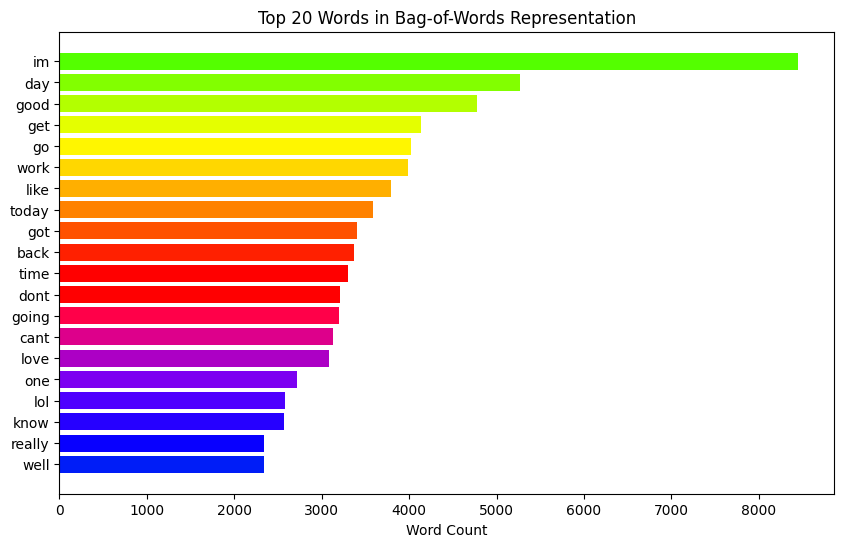

In [ ]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer=CountVectorizer(ngram_range=(1, 2), max_features = 500000)

countVec_train=count_vectorizer.fit_transform(x_train_countVec)
countVec_test=count_vectorizer.transform(x_test_countVec)

feature_names = count_vectorizer.get_feature_names_out()
word_counts = countVec_train.sum(axis=0).A1  # Sum across rows to get total counts for each word

# Create a DataFrame for visualization
bow_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts})

# Sort the DataFrame by word counts in descending order
bow_df = bow_df.sort_values(by='Count', ascending=False)

# Display the top 20 words with a colorful background using a different colormap (inferno)
top_words = 20
colors = plt.cm.prism_r(range(top_words))

plt.figure(figsize=(10, 6))
bars = plt.barh(bow_df['Word'][:top_words], bow_df['Count'][:top_words], color=colors)
plt.xlabel('Word Count')
plt.title('Top 20 Words in Bag-of-Words Representation')

# Add a colorful background
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)

plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## **Naive Bayes**

In [ ]:
naiveByes = MultinomialNB()
naiveByes.fit(countVec_train, y_train_countVec)

MultinomialNB()

In [ ]:
NB_prediction = naiveByes.predict(countVec_test)
#Accuracy_score
accuracy_score(y_test_countVec, NB_prediction)*100

77.075

In [ ]:
nb_class_report = classification_report(y_test_countVec, NB_prediction)
print("Classification Report:\n", nb_class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78     10035
           1       0.80      0.72      0.76      9965

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



## **Decision Trees**

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(countVec_train, y_train_countVec)

DecisionTreeClassifier()

In [ ]:
D_T_prediction = decision_tree.predict(countVec_test)
#Accuracy_score
accuracy_score(y_test_countVec,D_T_prediction)*100

71.195

In [ ]:
class_report = classification_report(y_test_countVec, D_T_prediction)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.73      0.72     10035
           1       0.72      0.69      0.70      9965

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000



## **Logistic Regression**

In [ ]:
logistic = LogisticRegression(solver='saga', C = 2, max_iter = 1000)
logistic.fit(countVec_train, y_train_countVec)

LogisticRegression(C=2, max_iter=1000, solver='saga')

In [ ]:
logistic_pred = logistic.predict(countVec_test)
#Accuracy_score
accuracy_score(y_test_countVec,logistic_pred)*100

77.945

In [ ]:
class_report = classification_report(y_test_countVec, logistic_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78     10035
           1       0.77      0.79      0.78      9965

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



## **XGBoost**

In [ ]:
xgb = XGBClassifier(learning_rate=1, n_estimators=200, max_depth=6)
xgb.fit(countVec_train, y_train_countVec)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pred = xgb.predict(countVec_test)
#Accuracy_score
accuracy_score(y_test_countVec,xgb_pred)*100

76.31

In [ ]:
class_report = classification_report(y_test_countVec, xgb_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     10035
           1       0.75      0.79      0.77      9965

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



## **TF-IDF Vectorizer**

## **Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset["Clean_Tweet"], dataset["Sentiment"], test_size = 0.2, random_state = 42)

In [ ]:
tfidfVectorizer = TfidfVectorizer(ngram_range = (1,2), max_features = 500000)

# Fit and transform the training data
x_train_tfidf = tfidfVectorizer.fit_transform(x_train)

# Transform the test data
x_test_tfidf = tfidfVectorizer.transform(x_test)

### **Random Forest**

In [ ]:
#TF-IDF
model = RandomForestClassifier()
model.fit(x_train_tfidf,y_train)

RandomForestClassifier()

In [ ]:
random_pred = model.predict(x_test_tfidf)
#Accuracy_score
accuracy_score(y_test,random_pred)*100
#print(f"Model training time: {end_time - start_time:.2f} seconds")

76.345

In [ ]:
rf_class_report = classification_report(y_test, random_pred)
print("Classification Report:\n", rf_class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77     10035
           1       0.77      0.74      0.76      9965

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



### **Naive Beyes**

In [ ]:
naiveByes = MultinomialNB()
naiveByes.fit(x_train_tfidf,y_train)


MultinomialNB()

In [ ]:
NB_prediction = naiveByes.predict(x_test_tfidf)
#Accuracy_score
accuracy_score(y_test,NB_prediction)*100

77.515

In [ ]:
nb_class_report = classification_report(y_test, NB_prediction)
print("Classification Report:\n", nb_class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79     10035
           1       0.81      0.72      0.76      9965

    accuracy                           0.78     20000
   macro avg       0.78      0.77      0.77     20000
weighted avg       0.78      0.78      0.77     20000



### **Logistic Regression**

In [ ]:
logistic = LogisticRegression(solver='liblinear', C = 2, max_iter = 1000)
logistic.fit(x_train_tfidf,y_train)

LogisticRegression(C=2, max_iter=1000, solver='liblinear')

In [ ]:
logistic_pred = logistic.predict(x_test_tfidf)

In [ ]:
#Accuracy_score
accuracy_score(y_test,logistic_pred)*100

78.015

In [ ]:
class_report = classification_report(y_test, logistic_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     10035
           1       0.79      0.77      0.78      9965

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



### **Decision Tree**

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train_tfidf,y_train)

DecisionTreeClassifier()

In [ ]:
D_T_prediction = decision_tree.predict(x_test_tfidf)

In [ ]:
#Accuracy_score
accuracy_score(y_test,D_T_prediction)*100

70.0

In [ ]:
class_report = classification_report(y_test, D_T_prediction)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70     10035
           1       0.70      0.69      0.70      9965

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



### **XGBoost**

In [ ]:
xgb = XGBClassifier(learning_rate=1, n_estimators=200, max_depth=6)
xgb.fit(x_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pred = xgb.predict(x_test_tfidf)

In [ ]:
#Accuracy_score
accuracy_score(y_test,xgb_pred)*100

75.22999999999999

In [ ]:
class_report = classification_report(y_test, xgb_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.75     10035
           1       0.75      0.75      0.75      9965

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



## **CNN-LSTM**

In [ ]:
#CNN-LSTM
max_features = 20000
max_words = 1000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(dataset['Clean_Tweet'].values)
X = tokenizer.texts_to_sequences(dataset['Clean_Tweet'].values)
X = pad_sequences(X, maxlen=max_words)
y = pd.get_dummies(dataset['Sentiment']).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
print("Shape of train data:", X_train.shape)
print("Shape of Test data:", X_test.shape)

Shape of train data: (80000, 1000)
Shape of Test data: (20000, 1000)


In [ ]:

from keras.callbacks import ModelCheckpoint
embed_dim = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1000, 100)         2000000   
                                                                 
 conv1d_12 (Conv1D)          (None, 1000, 32)          9632      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 500, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 500, 32)           3104      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 250, 32)           0         
 ng1D)                                                           
                                                                 
 lstm_6 (LSTM)               (None, 100)              

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128 ,verbose = 1, callbacks= callbacks_list, validation_data=(X_test,y_test))

Epoch 1/5
625/625 [==============================] - 274s 433ms/step - loss: 0.5123 - accuracy: 0.7426 - val_loss: 0.4573 - val_accuracy: 0.7800
Epoch 2/5
625/625 [==============================] - 262s 420ms/step - loss: 0.3946 - accuracy: 0.8248 - val_loss: 0.4662 - val_accuracy: 0.7752


## **CNN-BiLSTM**

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1000, 100)         2000000   
                                                                 
 conv1d_15 (Conv1D)          (None, 996, 128)          64128     
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 498, 128)          0         
 ng1D)                                                           
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               183200    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 2)                 402       
                                                                 
Total params: 2247730 (8.57 MB)
Trainable params: 2247

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128 ,verbose = 1, callbacks= callbacks_list, validation_data=(X_test,y_test))

Epoch 1/5
625/625 [==============================] - 1014s 2s/step - loss: 0.5118 - accuracy: 0.7429 - val_loss: 0.4606 - val_accuracy: 0.7804
Epoch 2/5
625/625 [==============================] - 983s 2s/step - loss: 0.3964 - accuracy: 0.8215 - val_loss: 0.4718 - val_accuracy: 0.7776


## **LSTM**

In [ ]:

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)]
history = model.fit(X_train, y_train, epochs=5, batch_size=128 ,verbose = 1, callbacks= callbacks_list, validation_data=(X_test,y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1000, 100)         2000000   
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 2080602 (7.94 MB)
Trainable params: 2080602 (7.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
625/625 [==============================] - 1105s 2s/step - loss: 0.5143 - accuracy: 0.7425 - val_loss: 0.4591 - val_accuracy: 0.7724
Epoch 2/5
625/625 [==============================] - 1091s 2s/step - loss: 0.4218 - accuracy: 0.8053 - val_loss: 0.4636 - val_accur

## **CNN**

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
modelCNN = Sequential()
modelCNN.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
modelCNN.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
modelCNN.add(GlobalMaxPooling1D())
modelCNN.add(Dense(units=64, activation='relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)]
history = model.fit(X_train, y_train, epochs=5, batch_size=128 ,verbose = 1, callbacks= callbacks_list, validation_data=(X_test,y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1000, 100)         2000000   
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 2080602 (7.94 MB)
Trainable params: 2080602 (7.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
625/625 [==============================] - 1097s 2s/step - loss: 0.4216 - accuracy: 0.8064 - val_loss: 0.4661 - val_accuracy: 0.7762
Epoch 2/5
625/625 [==============================] - 1058s 2s/step - loss: 0.3801 - accuracy: 0.8280 - val_loss: 0.4934 - val_accur